<a href="https://colab.research.google.com/github/paulanavarretec/WineRec/blob/master/wineRec_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from google.colab import files
#uploaded = files.upload()

# Get reviews into data structures

In [2]:
import numpy as np
import pandas as pd

!pip install gensim
import gensim

### Read data file
_reviews = pd.read_csv('Reviews_no_nan.csv',
                         sep=';',
                         names = ['userID','review', 'review_URL','score','sentiment','date_string', 
                                  'vintage', 'type', 'producer', 'variety', 'designation', 'vineyard', 
                                  'country', 'region', 'subregion', 'appellation', 'price_level'],
                         header=0)


### Check for Descriptive Information
print("Matrix size",_reviews.shape) # view dataframe size
print("Column Names:",_reviews.columns) # view columns using df.columns

### Data overview
#_reviews.head()
_reviews.tail()

### No null Reviews allowed
print("NaNs:",_reviews['review'].isna().sum())

### Get null's source
df = _reviews[_reviews['review'].notnull()]
_df = _reviews[_reviews['review'].isna()]
reviews = _reviews[_reviews['review'].notnull()]
print("Nulls:",_df)

### Preprocess review's texts for later encoding
documents = []
for i in range(len(df)):    
    documents.append(gensim.utils.simple_preprocess(df['review'].values[i]))

print(documents[0:3])


Matrix size (15748, 17)
Column Names: Index(['userID', 'review', 'review_URL', 'score', 'sentiment', 'date_string',
       'vintage', 'type', 'producer', 'variety', 'designation', 'vineyard',
       'country', 'region', 'subregion', 'appellation', 'price_level'],
      dtype='object')
NaNs: 0
Nulls: Empty DataFrame
Columns: [userID, review, review_URL, score, sentiment, date_string, vintage, type, producer, variety, designation, vineyard, country, region, subregion, appellation, price_level]
Index: []
[['check', 'out', 'this', 'unique', 'wine', 'from', 'the', 'big', 'island', 'of', 'hawaii', 'crafted', 'from', 'white', 'grapes', 'blended', 'with', 'berries', 'for', 'good', 'blush', 'very', 'suitable', 'for', 'summer', 'sipping', 'it', 'has', 'light', 'raisin', 'hue', 'at', 'first', 'pour', 'but', 'seemed', 'to', 'change', 'its', 'tint', 'after', 'being', 'opened', 'for', 'several', 'minutes', 'this', 'wine', 'exhibited', 'cranberry', 'flavors', 'with', 'slight', 'sweetness', 'interesti

# Reviews text Embedding

Hacemos el embedding de cada review con doc2vec provisto por gensim.

In [3]:
#from gensim.test.utils import common_texts # Use when real data IS NOT available
common_texts = documents # Use when real data IS available

len(common_texts)

15748

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Learn corpus to vectorize reviews
tagged_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(tagged_documents, vector_size=10, window=2, min_count=1, workers=4)

In [5]:
### Simple Example

print(documents[0])
vector = model.infer_vector(documents[0])
print(vector)

['check', 'out', 'this', 'unique', 'wine', 'from', 'the', 'big', 'island', 'of', 'hawaii', 'crafted', 'from', 'white', 'grapes', 'blended', 'with', 'berries', 'for', 'good', 'blush', 'very', 'suitable', 'for', 'summer', 'sipping', 'it', 'has', 'light', 'raisin', 'hue', 'at', 'first', 'pour', 'but', 'seemed', 'to', 'change', 'its', 'tint', 'after', 'being', 'opened', 'for', 'several', 'minutes', 'this', 'wine', 'exhibited', 'cranberry', 'flavors', 'with', 'slight', 'sweetness', 'interestingly', 'enough', 'there', 'is', 'also', 'bit', 'of', 'acidity', 'to', 'the', 'finish', 'no', 'volcanoes', 'were', 'harmed', 'in', 'making', 'this', 'wine', 'so', 'open', 'up', 'and', 'enjoy', 'with', 'clear', 'conscience', 'you', 'might', 'be', 'able', 'to', 'find', 'it', 'in', 'some', 'specialty', 'wine', 'stores', 'but', 'the', 'winery', 'does', 'ship', 'to', 'many', 'states', 'of', 'course', 'going', 'to', 'hawaii', 'and', 'buying', 'some', 'bottles', 'as', 'well', 'as', 'sampling', 'the', 'wineries'

In [6]:
### Now for all reviews

documents_vectors = []
for i in range(len(documents)):    
    documents_vectors.append(model.infer_vector(documents[i]))
documents_vectors = np.asarray(documents_vectors)

### Vectorized reviews overlook
(documents_vectors[0:3])

array([[-0.20882584, -0.15886697,  0.45883006,  0.17990914,  0.16787708,
         0.05174761,  0.16210464, -0.21372154, -0.24856399,  0.5403971 ],
       [-0.03299998, -0.08123024,  0.19157518,  0.05729294,  0.25833946,
         0.11671361,  0.01404883, -0.14967872,  0.00969271,  0.14569242],
       [ 0.01811655, -0.01631032,  0.03836509,  0.0335442 ,  0.02933924,
         0.08084952,  0.07252195, -0.09292959, -0.02093284, -0.08723468]],
      dtype=float32)

In [7]:
### Sanity check for dimensions
documents_vectors.shape

(15748, 10)

#Users, items y features representation

In [8]:
print("Matrix size",reviews.shape)

#reviews.head()
reviews.tail()

Matrix size (15748, 17)


,userID,review,review_URL,score,sentiment,date_string,vintage,type,producer,variety,designation,vineyard,country,region,subregion,appellation,price_level
15743,BSpdx,This was really pretty awful. The nose actuall...,https://www.cellartracker.com/notes.asp?iWine=...,65,BSpdx wrote:,10/30/2007 - \nBSpdx wrote: \n\n65 Points,2004.0,Red,Mad Dogs & English Men,Red Blend,NaN,NaN,Spain,Extremadura,NaN,Vino de la Tierra Extremadura,1
15744,EricFromMD,OK. Lots of fruit (overextracted?) Was a decen...,https://www.cellartracker.com/notes.asp?iWine=...,84,EricFromMD wrote:,2/21/2007 - \nEricFromMD wrote: \n\n84 Points,2004.0,Red,Mad Dogs & English Men,Red Blend,NaN,NaN,Spain,Extremadura,NaN,Vino de la Tierra Extremadura,1
15745,Anonymous,Very sweet extracted wine. This was drinakable...,https://www.cellartracker.com/notes.asp?iWine=...,82,Anonymous wrote:,11/27/2006 - \nAnonymous wrote: \n\n82 Points,2004.0,Red,Mad Dogs & English Men,Red Blend,NaN,NaN,Spain,Extremadura,NaN,Vino de la Tierra Extremadura,1
15746,jrglm,Yuck,https://www.cellartracker.com/notes.asp?iWine=...,75,jrglm wrote:,3/22/2006 - \njrglm wrote: \n\n75 Points,2004.0,Red,Mad Dogs & English Men,Red Blend,NaN,NaN,Spain,Extremadura,NaN,Vino de la Tierra Extremadura,1
15747,Slipknot,whatever,https://www.cellartracker.com/notes.asp?iWine=...,80,Slipknot wrote:,11/15/2006 - \nSlipknot wrote: \n\n80 Points,2003.0,Red,Mad Dogs & English Men,Red Blend,NaN,NaN,Spain,Extremadura,NaN,Vino de la Tierra Extremadura,1


In [0]:
### Fill in the rare values with supported ones

reviews['vintage'] = reviews['vintage'].fillna(0).astype('int')
reviews['designation'] = reviews['designation'].fillna(0).astype('str')
reviews['vineyard'] = reviews['vineyard'].fillna(0).astype('str')
reviews['subregion'] = reviews['subregion'].fillna(0).astype('str')
reviews['appellation'] = reviews['appellation'].fillna(0).astype('str')


Nuestro review df variable contiene un pandas dataframe con XXXX reviews rows y 17 columnas con wines features. Todas excepto score, year y vintage son categorical features que deben ser codificadas para poder usarlas como input en los algoritmos de aprendizaje.

In [10]:
# import preprocessing from sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

### Encode all categorical data to integers to be able to do some math on it

reviews['user_id'] = label_encoder.fit_transform(reviews.userID)
reviews['item_id'] = label_encoder.fit_transform(reviews.review_URL)
reviews['type_encoded'] = label_encoder.fit_transform(reviews.type)
reviews['producer_encoded'] = label_encoder.fit_transform(reviews.producer)
reviews['variety_encoded'] = label_encoder.fit_transform(reviews.variety)
reviews['designation_encoded'] = label_encoder.fit_transform(reviews.designation)
reviews['vineyard_encoded'] = label_encoder.fit_transform(reviews.vineyard)
reviews['country_encoded'] = label_encoder.fit_transform(reviews.country)
reviews['region_encoded'] = label_encoder.fit_transform(reviews.region)
reviews['subregion_encoded'] = label_encoder.fit_transform(reviews.subregion)
reviews['appellation_encoded'] = label_encoder.fit_transform(reviews.appellation)

print("Column Names:",reviews.columns) # view columns using df.columns
reviews.tail(5)


Column Names: Index(['userID', 'review', 'review_URL', 'score', 'sentiment', 'date_string',
       'vintage', 'type', 'producer', 'variety', 'designation', 'vineyard',
       'country', 'region', 'subregion', 'appellation', 'price_level',
       'user_id', 'item_id', 'type_encoded', 'producer_encoded',
       'variety_encoded', 'designation_encoded', 'vineyard_encoded',
       'country_encoded', 'region_encoded', 'subregion_encoded',
       'appellation_encoded'],
      dtype='object')


,userID,review,review_URL,score,sentiment,date_string,vintage,type,producer,variety,...,item_id,type_encoded,producer_encoded,variety_encoded,designation_encoded,vineyard_encoded,country_encoded,region_encoded,subregion_encoded,appellation_encoded
15743,BSpdx,This was really pretty awful. The nose actuall...,https://www.cellartracker.com/notes.asp?iWine=...,65,BSpdx wrote:,10/30/2007 - \nBSpdx wrote: \n\n65 Points,2004,Red,Mad Dogs & English Men,Red Blend,...,803,2,968,180,9,0,2,22,0,343
15744,EricFromMD,OK. Lots of fruit (overextracted?) Was a decen...,https://www.cellartracker.com/notes.asp?iWine=...,84,EricFromMD wrote:,2/21/2007 - \nEricFromMD wrote: \n\n84 Points,2004,Red,Mad Dogs & English Men,Red Blend,...,803,2,968,180,9,0,2,22,0,343
15745,Anonymous,Very sweet extracted wine. This was drinakable...,https://www.cellartracker.com/notes.asp?iWine=...,82,Anonymous wrote:,11/27/2006 - \nAnonymous wrote: \n\n82 Points,2004,Red,Mad Dogs & English Men,Red Blend,...,803,2,968,180,9,0,2,22,0,343
15746,jrglm,Yuck,https://www.cellartracker.com/notes.asp?iWine=...,75,jrglm wrote:,3/22/2006 - \njrglm wrote: \n\n75 Points,2004,Red,Mad Dogs & English Men,Red Blend,...,803,2,968,180,9,0,2,22,0,343
15747,Slipknot,whatever,https://www.cellartracker.com/notes.asp?iWine=...,80,Slipknot wrote:,11/15/2006 - \nSlipknot wrote: \n\n80 Points,2003,Red,Mad Dogs & English Men,Red Blend,...,3884,2,968,180,9,0,2,22,0,343


## Item representation

In [11]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()

### Create dummies for items and users
user_id_ = onehotencoder.fit_transform(reviews.user_id.values.reshape(-1,1)).toarray()
item_id_ = onehotencoder.fit_transform(reviews.item_id.values.reshape(-1,1)).toarray()
vintage_ = onehotencoder.fit_transform(reviews.vintage.values.reshape(-1,1)).toarray()
type_encoded_ = onehotencoder.fit_transform(reviews.type_encoded.values.reshape(-1,1)).toarray()
producer_encoded_ = onehotencoder.fit_transform(reviews.producer_encoded.values.reshape(-1,1)).toarray()
variety_encoded_ = onehotencoder.fit_transform(reviews.variety_encoded.values.reshape(-1,1)).toarray()
designation_encoded_ = onehotencoder.fit_transform(reviews.designation_encoded.values.reshape(-1,1)).toarray()
vineyard_encoded_ = onehotencoder.fit_transform(reviews.vineyard_encoded.values.reshape(-1,1)).toarray()
country_encoded_ = onehotencoder.fit_transform(reviews.country_encoded.values.reshape(-1,1)).toarray()
region_encoded_ = onehotencoder.fit_transform(reviews.region_encoded.values.reshape(-1,1)).toarray()
subregion_encoded_ = onehotencoder.fit_transform(reviews.subregion_encoded.values.reshape(-1,1)).toarray()
appellation_encoded_ = onehotencoder.fit_transform(reviews.appellation_encoded.values.reshape(-1,1)).toarray()

print(user_id_[0:3])
print("Users dimensions:",user_id_.shape)

item_id_OneHot = pd.DataFrame(item_id_, columns = ["item_"+str((i)) for i in range(item_id_.shape[1])])
user_id_OneHot = pd.DataFrame(user_id_, columns = ["user_"+str((i)) for i in range(user_id_.shape[1])])
vintage_OneHot = pd.DataFrame(vintage_, columns = ["vintage_"+str((i)) for i in range(vintage_.shape[1])])
type_encoded_OneHot = pd.DataFrame(type_encoded_, columns = ["type_"+str((i)) for i in range(type_encoded_.shape[1])])
producer_encoded_OneHot = pd.DataFrame(producer_encoded_, columns = ["type_"+str((i)) for i in range(producer_encoded_.shape[1])])
variety_encoded_OneHot = pd.DataFrame(variety_encoded_, columns = ["type_"+str((i)) for i in range(variety_encoded_.shape[1])])
designation_encoded_OneHot = pd.DataFrame(designation_encoded_, columns = ["type_"+str((i)) for i in range(designation_encoded_.shape[1])])
vineyard_encoded_OneHot = pd.DataFrame(vineyard_encoded_, columns = ["type_"+str((i)) for i in range(vineyard_encoded_.shape[1])])
country_encoded_OneHot = pd.DataFrame(country_encoded_, columns = ["type_"+str((i)) for i in range(country_encoded_.shape[1])])
region_encoded_OneHot = pd.DataFrame(region_encoded_, columns = ["type_"+str((i)) for i in range(region_encoded_.shape[1])])
subregion_encoded_OneHot = pd.DataFrame(subregion_encoded_, columns = ["type_"+str((i)) for i in range(subregion_encoded_.shape[1])])
appellation_encoded_OneHot = pd.DataFrame(appellation_encoded_, columns = ["type_"+str((i)) for i in range(appellation_encoded_.shape[1])])

items = pd.concat([item_id_OneHot,
                   vintage_OneHot,
                   type_encoded_OneHot,
                   #producer_encoded_OneHot,
                   variety_encoded_OneHot,
                   #designation_encoded_OneHot,
                   #vineyard_encoded_OneHot,
                   country_encoded_OneHot,
                   region_encoded_OneHot,
                   #subregion_encoded_OneHot,
                   #appellation_encoded_OneHot
                  ], axis=1)
print("Item dimensions:",items.shape)
items.tail(13)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Users dimensions: (15748, 5475)
Item dimensions: (15748, 4507)


,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,type_78,type_79,type_80,type_81,type_82,type_83,type_84,type_85,type_86,type_87
15735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User representation

In [12]:
### Get date data in date format to be able to sort by review date

date = []
for i in range(len(reviews)):    
    date.append(reviews['date_string'][i].split(' -')[0])

date = pd.DataFrame(date)
date.columns = ['date']

date['date'] = pd.to_datetime(date.date)
date.head()


,date
0,2014-10-21
1,2009-06-05
2,2008-08-07
3,2007-10-05
4,2007-10-05


In [13]:
### Set new column with posts quantity set to zero and add date column to reviews df

reviews['posts_qty'] = 0 # to record experience in terms of posts made
reviews['tenure'] = 0    # to record experience in terms of time in system
users = pd.concat([user_id_OneHot,
                   pd.DataFrame(documents_vectors), 
                   date, 
                   reviews.posts_qty],axis=1)
users['ts'] = users.date.values.astype(np.float64)/float(pow(10,16))

reviews = pd.concat([reviews, users.date], axis=1)
print("Cantidad de usuarios unicos:",len(reviews.userID.unique()))
print(users.shape)
users.tail(13)


Cantidad de usuarios unicos: 5475
(15748, 5488)


,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,...,3,4,5,6,7,8,9,date,posts_qty,ts
15735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.355076,0.375973,0.313110,0.348063,-0.134291,-0.017504,0.284969,2008-06-03,0,121.24512
15736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.071112,-0.081123,0.037015,0.078439,-0.060607,0.060380,-0.050476,2008-02-17,0,120.32064
15737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.111781,-0.111287,0.144922,-0.096415,0.212723,0.021114,-0.017054,2008-02-07,0,120.23424
15738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058098,-0.231746,0.303282,0.059093,0.072854,-0.113731,0.121290,2008-01-06,0,119.95776
15739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033174,0.022616,0.081378,0.051068,0.058641,-0.123006,0.066255,2007-10-15,0,119.24064
15740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052710,0.108501,-0.021572,-0.014858,-0.114465,0.014571,0.055128,2007-08-11,0,118.67904
15741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034290,-0.027651,0.125238,-0.064785,0.072902,0.071379,-0.013230,2007-06-14,0,118.17792
15742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025872,0.152873,0.165483,-0.130588,0.066958,-0.111097,0.123157,2007-01-25,0,116.96832
15743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068180,0.107116,0.166041,0.218310,0.066150,-0.087340,0.236853,2007-10-30,0,119.37024
15744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.066304,0.089634,0.036925,0.051019,-0.044328,0.039849,0.017358,2007-02-21,0,117.20160


In [14]:
### loop to increment posts_qty by one in ascending date order

for i in range(len(reviews.userID.unique())):
    subset = reviews.loc[reviews['userID'] == reviews.userID.unique()[i]]
    subset = subset.sort_values(by='date')    
    idx = subset.index.tolist()
    #print(idx) # just to ease debugging and sanity checks

    i = 1
    start = float(users.iloc[idx[0]]['ts'])
    
    for index in idx:      
        current = float(users.iloc[idx[i-1]]['ts'])
        a = float(current-start)
        reviews.set_value(index, 'tenure', a)
        reviews.set_value(index, 'posts_qty', i)        
        i += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [15]:
### Sanity Check: posts_qty column should be in ascending order incremented by one in each row
subset = reviews.loc[reviews['userID'] == 'Anonymous']
subset = subset.sort_values(by='posts_qty')  
subset.head()

,userID,review,review_URL,score,sentiment,date_string,vintage,type,producer,variety,...,variety_encoded,designation_encoded,vineyard_encoded,country_encoded,region_encoded,subregion_encoded,appellation_encoded,posts_qty,tenure,date
14321,Anonymous,Tasted at the Denver offline with WIML on 5/12...,https://www.cellartracker.com/notes.asp?iWine=...,92,Anonymous wrote:,5/12/2003 - \nAnonymous wrote: \n\n92 Points,2000,White - Fortified,Alvear,Pedro Ximénez,...,154,848,0,2,3,0,193,1,0,2003-05-12
3291,Anonymous,Find of the year! I still can't get over the f...,https://www.cellartracker.com/notes.asp?iWine=...,93,Anonymous wrote:,9/20/2004 - \nAnonymous wrote: \n\n93 Points,0,White - Sparkling,Herbert Beaufort,Champagne Blend,...,36,332,0,0,16,0,74,2,4,2004-09-20
5583,Anonymous,Lovely floral nose. Nice balance of acidity an...,https://www.cellartracker.com/notes.asp?iWine=...,85,Anonymous wrote:,11/25/2004 - \nAnonymous wrote: \n\n85 Points,2000,White,Ajello,White Blend,...,245,131,0,1,71,0,258,3,4,2004-11-25
3410,Anonymous,good $22 bottle of champagne. Maybe a bit sweet.,https://www.cellartracker.com/notes.asp?iWine=...,90,Anonymous wrote:,3/25/2005 - \nAnonymous wrote: \n\n90 Points,0,White - Sparkling,Etienne DuMont,Chardonnay,...,38,9,0,0,16,0,73,4,5,2005-03-25
8418,Anonymous,"Deep ruby. On the nose, licorice, dark fruit, ...",https://www.cellartracker.com/notes.asp?iWine=...,90,Anonymous wrote:,3/29/2005 - \nAnonymous wrote: \n\n90 Points,2001,Red,Di Majo Norante,Aglianico,...,0,289,0,1,53,0,185,5,5,2005-03-29


## Feature Vectors

In [0]:
tenure_ = onehotencoder.fit_transform(reviews.tenure.values.reshape(-1,1)).toarray()
posts_qty_ = onehotencoder.fit_transform(reviews.posts_qty.values.reshape(-1,1)).toarray()

tenure_OneHot = pd.DataFrame(tenure_, columns = ["item_"+str((i)) for i in range(tenure_.shape[1])])
posts_qty_OneHot = pd.DataFrame(posts_qty_, columns = ["item_"+str((i)) for i in range(posts_qty_.shape[1])])

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = pd.concat([reviews.tenure,
                   reviews.posts_qty
                   ],axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(scaled))

users = pd.concat([user_id_OneHot,
                   #pd.DataFrame(documents_vectors),
                   scaled_data,              
                   #tenure_OneHot,  
                   #posts_qty_OneHot
                  ],axis=1)

features = pd.concat([items, users], axis=1)
print(features.shape)
features.tail(10)

(15748, 9984)


,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,user_5467,user_5468,user_5469,user_5470,user_5471,user_5472,user_5473,user_5474,0,1
15738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.218577,-0.183366
15739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.678926,-0.277794
15740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.678926,-0.277794
15741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.563839,-0.214842
15742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.678926,-0.277794
15743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333664,-0.214842
15744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.678926,-0.246318
15745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587034,0.509108
15746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.678926,-0.277794
15747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.678926,-0.277794


In [0]:
scores = reviews['score']
scores.to_csv("scores.csv", sep='\n',index=False)

#Experiments

##FM

In [19]:
!pip install fastFM
from fastFM.datasets import make_user_item_regression
from sklearn.model_selection import train_test_split
import scipy as sc

In [0]:
features.fillna(0, inplace=True)
scores.fillna(0, inplace=True)

X = sc.sparse.csr_matrix(features.values).tocsr()
y = scores.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [21]:
print("Set size:",features.shape,"\nTraining set size:", X_train.shape,"\nTest set size:", X_test.shape )

Set size: (15748, 9984) 
Training set size: (11023, 9984) 
Test set size: (4725, 9984)


In [0]:
from fastFM import als
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time

# Measure time
start_time = time.time()

n_iter = 500
step_size = 1
l2_reg_w = 0
l2_reg_V = 0

#fm = als.FMRegression(n_iter=0, l2_reg_w=0.1, l2_reg_V=0.1, rank=4, random_state=42)
fm = als.FMRegression(n_iter=0, init_stdev=0.1, rank=8, random_state=123, l2_reg_w=0.1, l2_reg_V=0.1, l2_reg=0)


# Allocates and initalizes the model parameter.
fm.fit(X_train, y_train)

lapse = time.time()-start_time

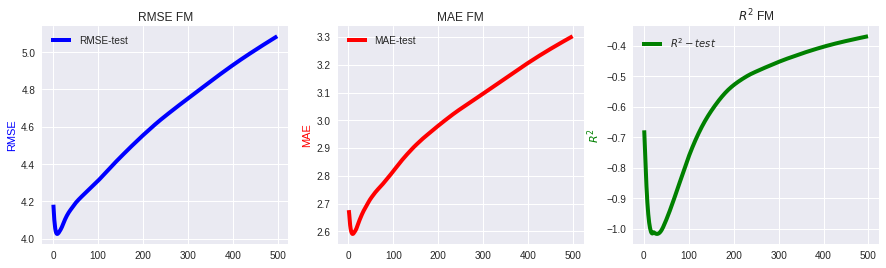

In [28]:
rmse_train = []
rmse_test = []

mae_train = []
mae_test = []

r2_train = []
r2_test = []

for i in range(1, n_iter):
    fm.fit(X_train, y_train, n_more_iter=step_size)
    y_pred = fm.predict(X_test)

    rmse_train.append(np.sqrt(mean_squared_error(fm.predict(X_train), y_train)))
    rmse_test.append(np.sqrt(mean_squared_error(fm.predict(X_test), y_test)))

    mae_train.append(mean_absolute_error(fm.predict(X_train), y_train))
    mae_test.append(mean_absolute_error(fm.predict(X_test), y_test))
    
    r2_train.append(r2_score(fm.predict(X_train), y_train, multioutput='variance_weighted'))
    r2_test.append(r2_score(fm.predict(X_test), y_test, multioutput='variance_weighted'))
    


from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

x = np.arange(1, n_iter) * step_size
with plt.style.context('fivethirtyeight'):
    
    axes[0].plot(x, rmse_test, label='RMSE-test', color='b')    
    axes[1].plot(x, mae_test, label='MAE-test', color='r')
    axes[2].plot(x, r2_test, label='$R^2-test$', color='g')
    
    
axes[0].set_ylabel('RMSE', color='b')
axes[1].set_ylabel('MAE', color='r')
axes[2].set_ylabel('$R^2$', color='g')

axes[0].set_title('RMSE FM')
axes[1].set_title('MAE FM')
axes[2].set_title('$R^2$ FM')

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.savefig('R2_RMSE_MAE_FM.png')

min_mae_fm = min(rmse_test)
min_rmse_fm = min(mae_test)

#from google.colab import files
#files.download('RMSE_MAE_FM.png')

### Zoom

min_mae_fm: 2.5904581378173814
min_rmse_fm: 4.025683589610356
Lapse: 3.482198715209961e-05 segs


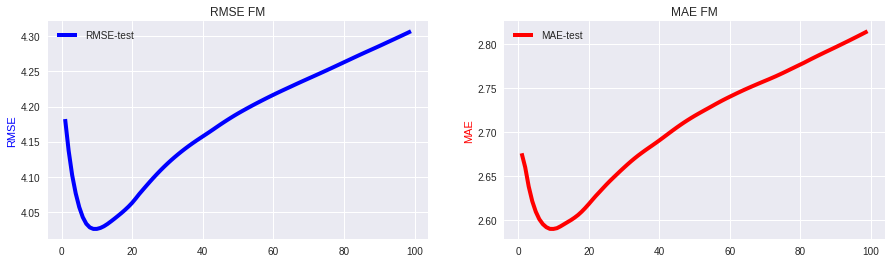

In [29]:
n_iter = 100

fm = als.FMRegression(n_iter=0, init_stdev=0.1, rank=8, random_state=123, l2_reg_w=0.1, l2_reg_V=0.1, l2_reg=0)

# Allocates and initalizes the model parameter.
fm.fit(X_train, y_train)

rmse_train = []
rmse_test = []

mae_train = []
mae_test = []

r2_train = []
r2_test = []

for i in range(1, n_iter):
    fm.fit(X_train, y_train, n_more_iter=step_size)
    y_pred = fm.predict(X_test)

    rmse_train.append(np.sqrt(mean_squared_error(fm.predict(X_train), y_train)))
    rmse_test.append(np.sqrt(mean_squared_error(fm.predict(X_test), y_test)))

    mae_train.append(mean_absolute_error(fm.predict(X_train), y_train))
    mae_test.append(mean_absolute_error(fm.predict(X_test), y_test))
    
    r2_train.append(r2_score(fm.predict(X_train), y_train, multioutput='variance_weighted'))
    r2_test.append(r2_score(fm.predict(X_test), y_test, multioutput='variance_weighted'))
    
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

x = np.arange(1, n_iter) * step_size
with plt.style.context('fivethirtyeight'):
    
    axes[0].plot(x, rmse_test, label='RMSE-test', color='b')    
    axes[1].plot(x, mae_test, label='MAE-test', color='r')
    
axes[0].set_ylabel('RMSE', color='b')
axes[1].set_ylabel('MAE', color='r')

axes[0].set_title('RMSE FM')
axes[1].set_title('MAE FM')

axes[0].legend()
axes[1].legend()

fig.savefig('R2_RMSE_MAE_FM_zoom.png')

min_rmse_fm = min(rmse_test)
min_mae_fm = min(mae_test)

print('min_mae_fm:',min_mae_fm)
print('min_rmse_fm:',min_rmse_fm)
print('Lapse:',lapse/1000,'segs')


## Data represention for baseline Experiments

In [0]:
reviews['ts'] = date.values.astype(np.int64)
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(reviews, scores, test_size=0.3, random_state=42) # for later use

df_y_train = df_y_train.to_frame()
df_y_train.columns = ['rating']

df_y_test = df_y_test.to_frame()
df_y_test.columns = ['rating']

In [31]:
print(len(df_X_train), len(df_X_test), type(df_y_train), type(df_y_test))
selected_columns = ['user_id','item_id','ts',
                    'vintage',
                    'type_encoded',
                    'producer_encoded',
                    'variety_encoded',
                    'designation_encoded',
                    'vineyard_encoded',
                    'country_encoded',
                    'region_encoded',
                    'subregion_encoded',
                    'appellation_encoded'
                   ]

df_X_train = df_X_train[selected_columns]
df_X_test = df_X_test[selected_columns]

#df_X_test.head()

11023 4725 <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [32]:
train_70 = pd.concat([df_X_train, df_y_train], axis=1)
train_30 = pd.concat([df_X_test, df_y_test], axis=1)

train_70.to_csv('train_70.csv', encoding='utf-8', index=False)
train_30.to_csv('train_30.csv', encoding='utf-8', index=False)

train_70.head()

,user_id,item_id,ts,vintage,type_encoded,producer_encoded,variety_encoded,designation_encoded,vineyard_encoded,country_encoded,region_encoded,subregion_encoded,appellation_encoded,rating
9943,4198,3026,1293148800000000000,2001,2,694,180,963,0,1,39,0,303,88
2354,1235,629,1423094400000000000,2010,10,889,70,9,0,0,2,0,10,81
6461,3271,3941,1339718400000000000,2007,2,300,194,9,0,1,80,28,191,90
14670,1093,2133,1187395200000000000,2005,2,449,221,927,0,2,56,0,203,87
7779,4934,2937,1243382400000000000,2006,10,294,236,301,0,1,69,0,310,88
